<div class="alert alert-info"><strong>Using the NYC Police Historic Incidents data, predict the number of home burglaries at Precinct #44, that will take place during the last three months of 2023.</strong><br><br>
The project involves predicting 'home' 'burglaries' for 'precinct 44'. For first quick trial, I will probably use some bruth force steps so that I can get a feeling...

The code takes into account seasonality in some of the trials. See comments along the notebook...

It would be intersting to present maps, showing the different precincts borders + times and counts of the different crimes...

The prediction can be address with the following approaches:
- LSTM
- Time Series

I selected Time Series as the first reaserch approach. I will try both Facebook's Prophet and SARIMA. Let's see...
</div>

In [1]:
# Following two lines are to force reload of changed module source files
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdinfo
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3)
np.set_printoptions(linewidth=100)
np.set_printoptions(suppress=True)

pd.set_option('float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Force all prints in a cell to show
# (https://ipython.readthedocs.io/en/stable/config/options/terminal.html, https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
# Load the data file

orig_file_name = 'NYPD_Complaint_Data_Historic_20240215.csv'
print('Loading data from: ' + orig_file_name)
df_orig = pd.read_csv(orig_file_name)


Loading data from: NYPD_Complaint_Data_Historic_20240215.csv


<div class="alert alert-info">Below I am using a Pandas extension that I have developed (called pdinfo) which helps me in analyzing the data.<br>
There is more to it than what is used below :-)</div>

In [3]:
# Below I am analayzing the data, producing an Excel file with the analysis and then, doing the same thing to the screen

df_orig.inf.to_excel()
 
result = df_orig.inf.info()
display(result)


Excel file 'info.xlsx' created successfully.
Dataframe name:    df_orig
Memory usage:      14284.35 MB
Number of columns: 35
Number of rows:    8,359,721


,Column,Type,Missing,Missing %,Zeros,Zeros %,Sum,Min,Max,Unique,50%,75%,90%,95%,p-value
0,CMPLNT_NUM,object,0,0.000,0,0.00%,None,None,None,8358645,-,-,-,-,-
1,CMPLNT_FR_DT,object,655,0.008,0,0.00%,None,None,None,9490,-,-,-,-,-
2,CMPLNT_FR_TM,object,0,0.000,0,0.00%,None,None,None,1442,-,-,-,-,-
3,CMPLNT_TO_DT,object,1784220,21.343,0,0.00%,None,None,None,7645,-,-,-,-,-
4,CMPLNT_TO_TM,object,0,0.000,0,0.00%,None,None,None,1441,-,-,-,-,-
5,ADDR_PCT_CD,float64,701,0.008,0,0.00%,529374899.000,1.000,123.000,77,63.00,94.00,112.00,115.00,1.00: Gaussian
6,RPT_DT,object,0,0.000,0,0.00%,None,None,None,6209,-,-,-,-,-
7,KY_CD,int64,0,0.000,0,0.00%,2483278119,101,881,75,341.00,351.00,578.00,578.00,0.00: Non-gaussian
8,OFNS_DESC,object,0,0.000,0,0.00%,None,None,None,73,-,-,-,-,-
9,PD_CD,float64,7207,0.086,0,0.00%,3441679218.000,100.000,975.000,439,361.00,637.00,705.00,782.00,1.00: Gaussian


In [4]:
result = df_orig.inf.inspect()
print(result)



INSPECT DATAFRAME: df_orig

Checking for duplicate rows:
- No duplicate rows found.

Checking for duplicate columns:
- No duplicate columns found.

Checking for missing values:
- Found 11 columns with missing values.

Checking for category columns with rare values (threshhold=0.05):
- No rare values found.
None


<Axes: xlabel='OFNS_DESC'>

Text(0.5, 0, 'Crime Type')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'NYC Overall Top Crimes')

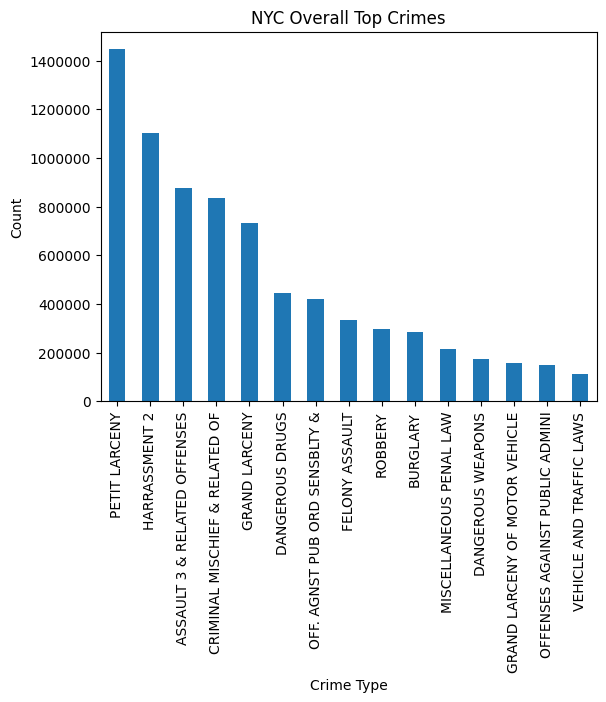

In [5]:
# Plot tha top crimes

df_orig['OFNS_DESC'].value_counts()[:15].plot.bar()
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.title('NYC Overall Top Crimes')
plt.ticklabel_format(style='plain', axis='y')


<div class="alert alert-info"><strong>From the above plot, we can see that BURGLARY is #10 which is fairly high</strong></div>

<Axes: xlabel='ADDR_PCT_CD'>

Text(0.5, 0, 'Precinct')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'NYC Top Precincts By Number Of Crimes')

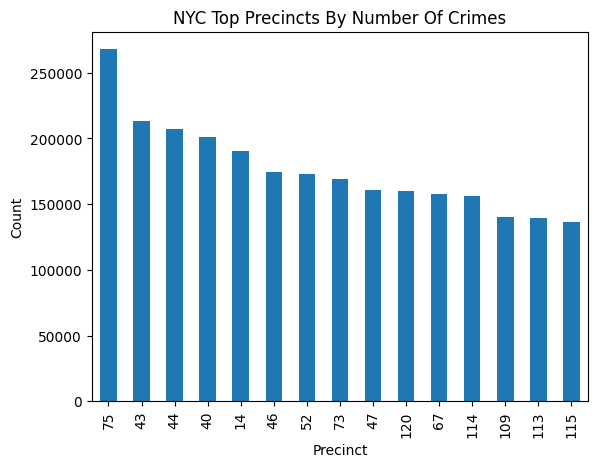

In [6]:
# Plot overall crimes per precinct

df_orig['ADDR_PCT_CD'] = df_orig['ADDR_PCT_CD'].fillna(0).astype(int)
df_orig['ADDR_PCT_CD'].value_counts()[:15].plot.bar()
plt.xlabel('Precinct')
plt.ylabel('Count')
plt.title('NYC Top Precincts By Number Of Crimes')
plt.ticklabel_format(style='plain', axis='y')


<div class="alert alert-info"><strong>Above graph shows precinct 44 as the third, which probably means that it requires higher attention by the police</strong></div>

In [7]:
# Frop non-needed columns for the first round of research

cols_to_drop = ['CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'HOUSING_PSA', 'JURISDICTION_CODE',
                'JURIS_DESC', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'PARKS_NM', 'PATROL_BORO', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP', 'SUSP_RACE',
                'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon', 'PD_DESC']

df_reduced = df_orig.drop(cols_to_drop, axis=1)

result = df_reduced.inf.info()                      # Present analysis
display(result)


Dataframe name:    df_reduced
Memory usage:      1862.34 MB
Number of columns: 6
Number of rows:    8,359,721


,Column,Type,Missing,Missing %,Zeros,Zeros %,Sum,Min,Max,Unique,50%,75%,90%,95%,p-value
0,CMPLNT_FR_DT,object,655,0.008,0,0.00%,None,None,None,9490,-,-,-,-,-
1,ADDR_PCT_CD,int32,0,0.000,701,0.01%,529374899,0,123,78,63.00,94.00,112.00,115.00,0.00: Non-gaussian
2,KY_CD,int64,0,0.000,0,0.00%,2483278119,101,881,75,341.00,351.00,578.00,578.00,0.00: Non-gaussian
3,OFNS_DESC,object,0,0.000,0,0.00%,None,None,None,73,-,-,-,-,-
4,PD_CD,float64,7207,0.086,0,0.00%,3441679218.000,100.000,975.000,439,361.00,637.00,705.00,782.00,1.00: Gaussian
5,PREM_TYP_DESC,object,0,0.000,0,0.00%,None,None,None,93,-,-,-,-,-


In [8]:
# Keep only precinct 44 data

df_44 = df_reduced[df_reduced.ADDR_PCT_CD == 44].copy()
df_44.inf.info()


Dataframe name:    df_44
Memory usage:      47.75 MB
Number of columns: 6
Number of rows:    207,265


,Column,Type,Missing,Missing %,Zeros,Zeros %,Sum,Min,Max,Unique,50%,75%,90%,95%,p-value
0,CMPLNT_FR_DT,object,5,0.002,0,0.00%,None,None,None,6462,-,-,-,-,-
1,ADDR_PCT_CD,int32,0,0.000,0,0.00%,9119660,44,44,1,44.00,44.00,44.00,44.00,1.00: Gaussian
2,KY_CD,int64,0,0.000,0,0.00%,61457982,101,678,62,341.00,351.00,578.00,578.00,0.00: Non-gaussian
3,OFNS_DESC,object,0,0.000,0,0.00%,None,None,None,57,-,-,-,-,-
4,PD_CD,float64,229,0.110,0,0.00%,86215318.000,101.000,922.000,341,397.00,637.00,729.00,782.00,1.00: Gaussian
5,PREM_TYP_DESC,object,0,0.000,0,0.00%,None,None,None,84,-,-,-,-,-


- To make my life easier for the first round, I just filtered out rows that the offense description did not include 'BURG'.
- Better analysis should be done, including full understanding of burglary types (and maybe filtering some items in or out).
- In addition, discussion should be held if we should handle burglary success/failure in some way.


In [9]:
# Keep only burglary crimes
#print([x for x in df_44.OFNS_DESC.unique() if 'BURG' in x])

# Not sure if to include "BURGLAR'S TOOLS". For the trial I will include them
df_44 = df_44[df_44.OFNS_DESC.str.contains('BURG')]
print(df_44.OFNS_DESC.value_counts())
df_44.inf.info()


OFNS_DESC
BURGLARY           4809
BURGLAR'S TOOLS      75
Name: count, dtype: int64
Dataframe name:    df_44
Memory usage:      1.10 MB
Number of columns: 6
Number of rows:    4,884


,Column,Type,Missing,Missing %,Zeros,Zeros %,Sum,Min,Max,Unique,50%,75%,90%,95%,p-value
0,CMPLNT_FR_DT,object,0,0.000,0,0.00%,None,None,None,3263,-,-,-,-,-
1,ADDR_PCT_CD,int32,0,0.000,0,0.00%,214896,44,44,1,44.00,44.00,44.00,44.00,1.00: Gaussian
2,KY_CD,int64,0,0.000,0,0.00%,531888,107,231,2,107.00,107.00,107.00,107.00,0.00: Non-gaussian
3,OFNS_DESC,object,0,0.000,0,0.00%,None,None,None,2,-,-,-,-,-
4,PD_CD,float64,0,0.000,0,0.00%,1081005.000,209.000,244.000,13,221.00,223.00,231.00,233.00,0.00: Non-gaussian
5,PREM_TYP_DESC,object,0,0.000,0,0.00%,None,None,None,58,-,-,-,-,-


In [10]:
# The project is targeted only at prediciting for "homes". So, we should filter out other location types.
# Should I also include 'PARKING LOT/GARAGE (PRIVATE)'?

df_44 = df_44[df_44.PREM_TYP_DESC.str.contains('RESIDENCE')]
print(df_44.PREM_TYP_DESC.value_counts())


PREM_TYP_DESC
RESIDENCE - APT. HOUSE        2942
RESIDENCE-HOUSE                211
RESIDENCE - PUBLIC HOUSING     116
Name: count, dtype: int64


In [11]:
# Drop non-needed columns

cols_to_drop = ['ADDR_PCT_CD', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC']
df_44.drop(cols_to_drop, axis=1, inplace=True)
df_44.inf.info()
df_44.head()


Dataframe name:    df_44
Memory usage:      0.23 MB
Number of columns: 1
Number of rows:    3,269


,Column,Type,Missing,Missing %,Zeros,Zeros %,Sum,Min,Max,Unique,50%,75%,90%,95%,p-value
0,CMPLNT_FR_DT,object,0,0.000,0,0.00%,None,None,None,2448,-,-,-,-,-


,CMPLNT_FR_DT
292040,07/11/2006
298614,10/07/2006
304988,09/07/2006
308287,06/06/2006
375520,01/19/2006


In [12]:
# Convert dates to datetime and set all day of month entries to 1, so that we can handle on a monthly level

df_final = df_44.copy().reset_index(drop=True)
df_final['CMPLNT_FR_DT'] = pd.to_datetime(df_final['CMPLNT_FR_DT'], format='%m/%d/%Y').apply(lambda x: x.replace(day=1))
df_final.rename(columns={'CMPLNT_FR_DT': 'burglary_date'}, inplace=True)
print(df_final.burglary_date.min())
print(df_final.burglary_date.max())
df_final.head(10)


2005-11-01 00:00:00
2022-12-01 00:00:00


,burglary_date
0,2006-07-01
1,2006-10-01
2,2006-09-01
3,2006-06-01
4,2006-01-01
5,2006-09-01
6,2006-11-01
7,2006-08-01
8,2006-08-01
9,2006-01-01


In [13]:
# Create a dataframe to hold the sorted (by month) burgalies per month 

df_final_counts = df_final.burglary_date.value_counts().to_frame().sort_values(by=['burglary_date']).reset_index()
df_final_counts.info()
df_final_counts.head()
df_final_counts.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   burglary_date  206 non-null    datetime64[ns]
 1   count          206 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.3 KB


,burglary_date,count
0,2005-11-01,1
1,2005-12-01,1
2,2006-01-01,18
3,2006-02-01,8
4,2006-03-01,11


,burglary_date,count
201,2022-08-01,18
202,2022-09-01,18
203,2022-10-01,13
204,2022-11-01,15
205,2022-12-01,14


In [14]:
# Remove the two months of 2005 so that we have full years data

df_final_counts = df_final_counts[df_final_counts.burglary_date.dt.year >= 2006].reset_index(drop=True)
print(df_final_counts.head())
print(len(df_final_counts))


  burglary_date  count
0    2006-01-01     18
1    2006-02-01      8
2    2006-03-01     11
3    2006-04-01     17
4    2006-05-01     15
204


In [15]:
# Verify that we have data for all months
(df_final_counts.burglary_date.dt.year.max() - df_final_counts.burglary_date.dt.year.min() + 1) * 12

204

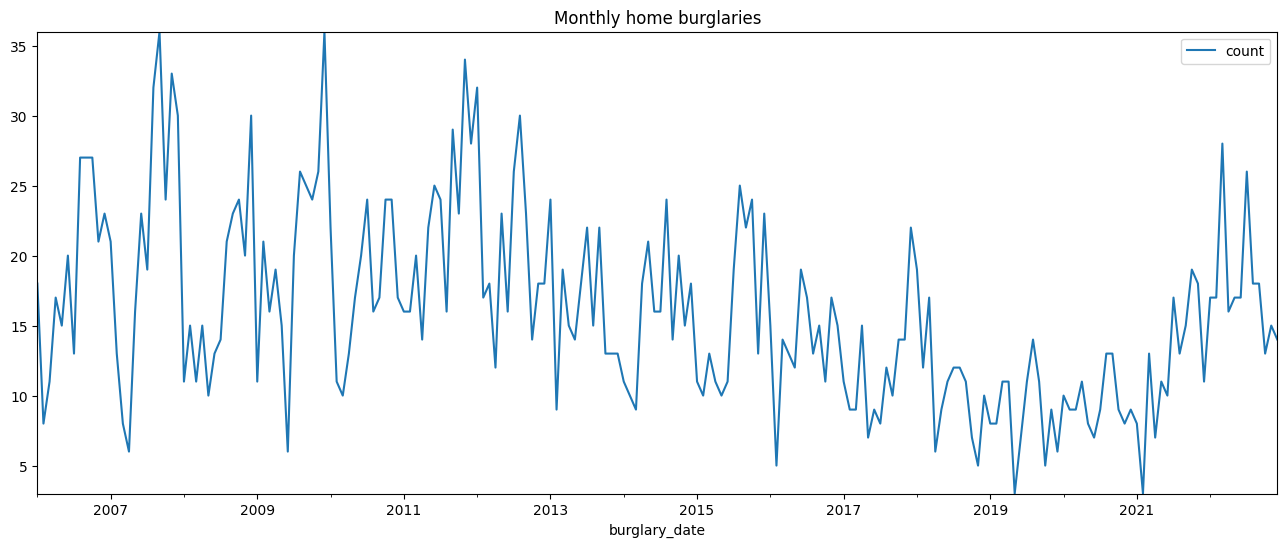

In [16]:
df_final_counts.plot('burglary_date', 'count', figsize=(16, 6), title='Monthly home burglaries').autoscale(axis='both', tight=True)


<div class="alert alert-info"><strong>
The above graph shows/hints to a few things that should be further investigated:</strong><br>
- Seasionality effects (see below plots and trials)<br>
- Burglaries count changes per month can be also attributed to the day of week (maybe more burgalries happen during the weekend and holidays, when people travel outside of their houses), police headcount changes over time and number of patrols done during certain days, etc.
- Need to investigate the crimes density (crimes compared to population in the precinct)<br>
- Number of crimes should also be dependent on the type of neighborhood (private houses vs. towers) and the type of people that live there (e.g. income level, average age)<br>
</div>


<Axes: >

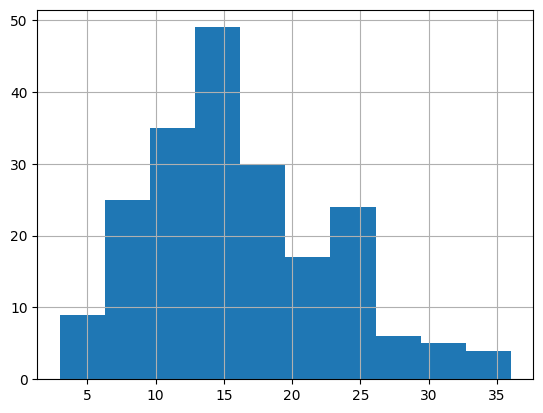

In [17]:
df_final_counts['count'].hist(bins=10)

<Axes: xlabel='month'>

Text(0.5, 0, 'Month')

([<matplotlib.axis.XTick at 0x22b2a8ef5e0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

Text(0, 0.5, 'Number Of Home Burglaries In Precinct 44')

Text(0.5, 1.0, 'Overall Home Burglaries Per Month In Precinct 44')

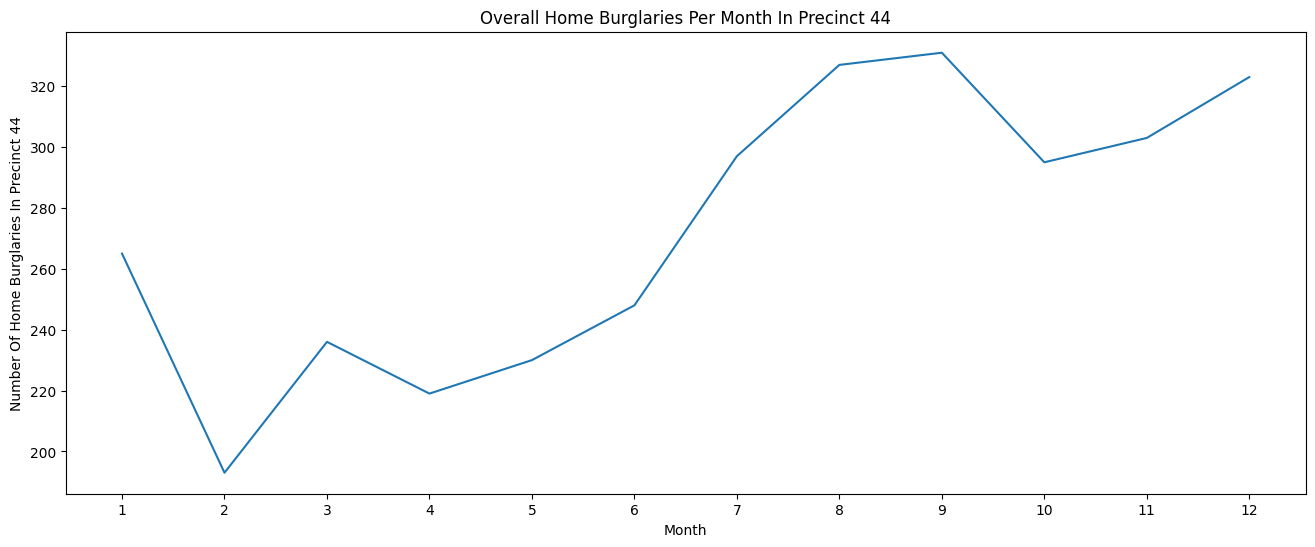

In [18]:
# Plot the burglaries distribution in precintc 44 per month of the year, to show possible seasonality

df = df_final_counts.copy()
df['month'] = df['burglary_date'].dt.month
df = df.drop('burglary_date', axis=1)
#print(df)

fig = plt.figure(figsize=(16, 6))
df.groupby('month')['count'].sum().plot(kind='line')
plt.xlabel('Month')
plt.xticks([x for x in range(1,13)])
plt.ylabel('Number Of Home Burglaries In Precinct 44')
plt.title('Overall Home Burglaries Per Month In Precinct 44')


<div class="alert alert-info"><strong>
Above plot shows burglary seasonality across the year. It is evident that the summer is prone to most burglaries.
</strong></div>

<div class="alert alert-info"><strong>
TRY TO PREDICT USING FACEBOOK'S PROPHET
</strong></div>

In [95]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


In [96]:
df_final_counts.columns = ['ds','y']
df_final_counts.head()

,ds,y
0,2006-01-01,18
1,2006-02-01,8
2,2006-03-01,11
3,2006-04-01,17
4,2006-05-01,15


In [97]:
cut_of_month = '2021-12'
train = df_final_counts[df_final_counts.ds <= cut_of_month]
test  = df_final_counts[df_final_counts.ds > cut_of_month]
train.shape
test.shape


(192, 2)

(12, 2)

In [119]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')

m.fit(train)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)


11:16:16 - cmdstanpy - INFO - Chain [1] start processing
11:16:16 - cmdstanpy - INFO - Chain [1] done processing


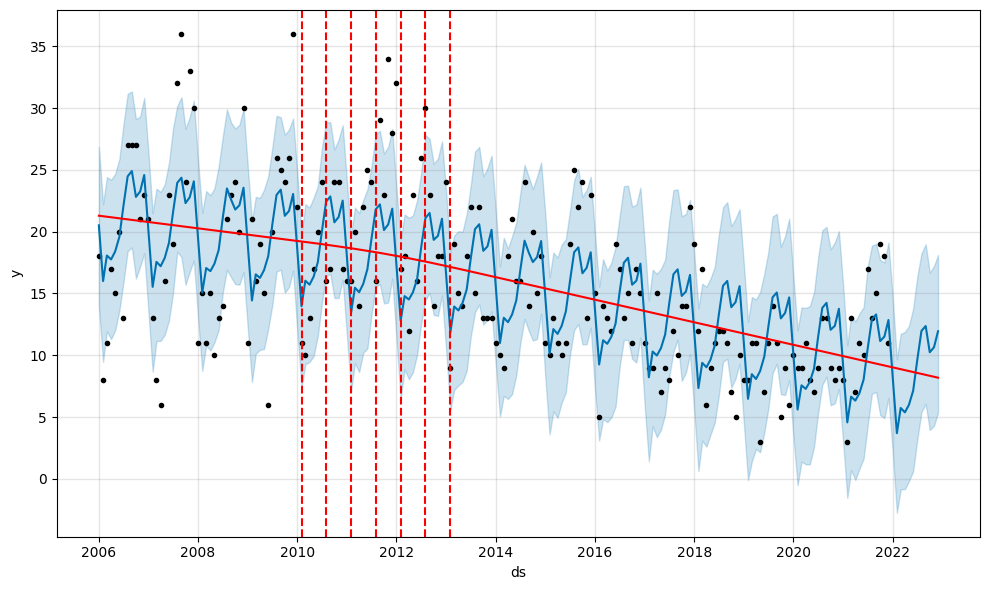

In [120]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


<Axes: xlabel='ds'>

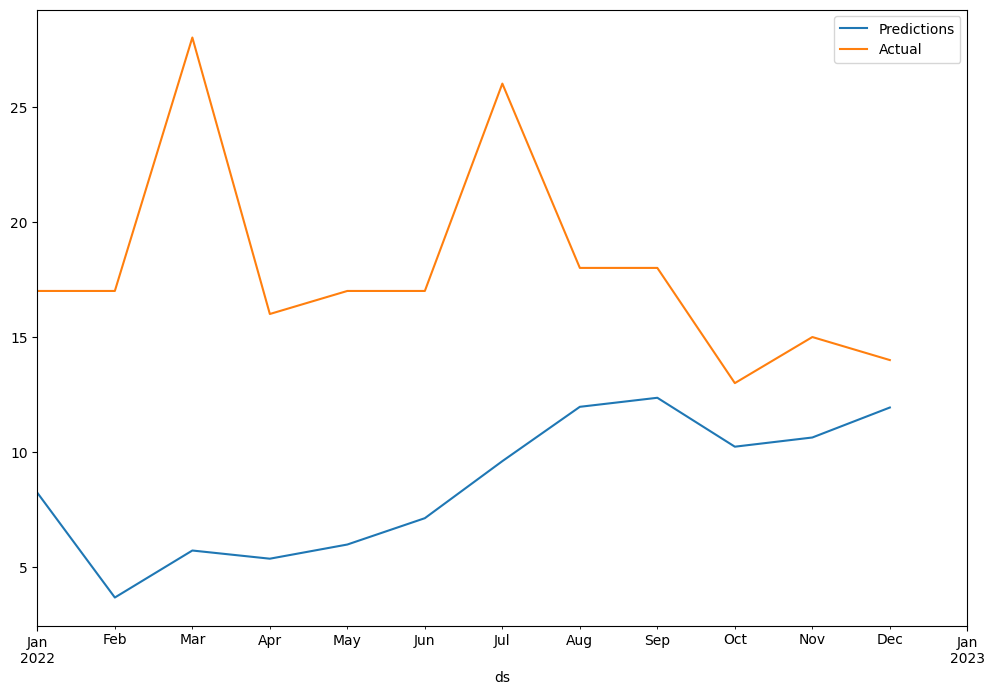

In [121]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Actual',legend=True, ax=ax, xlim=('2022-01-01','2023-01-01'))


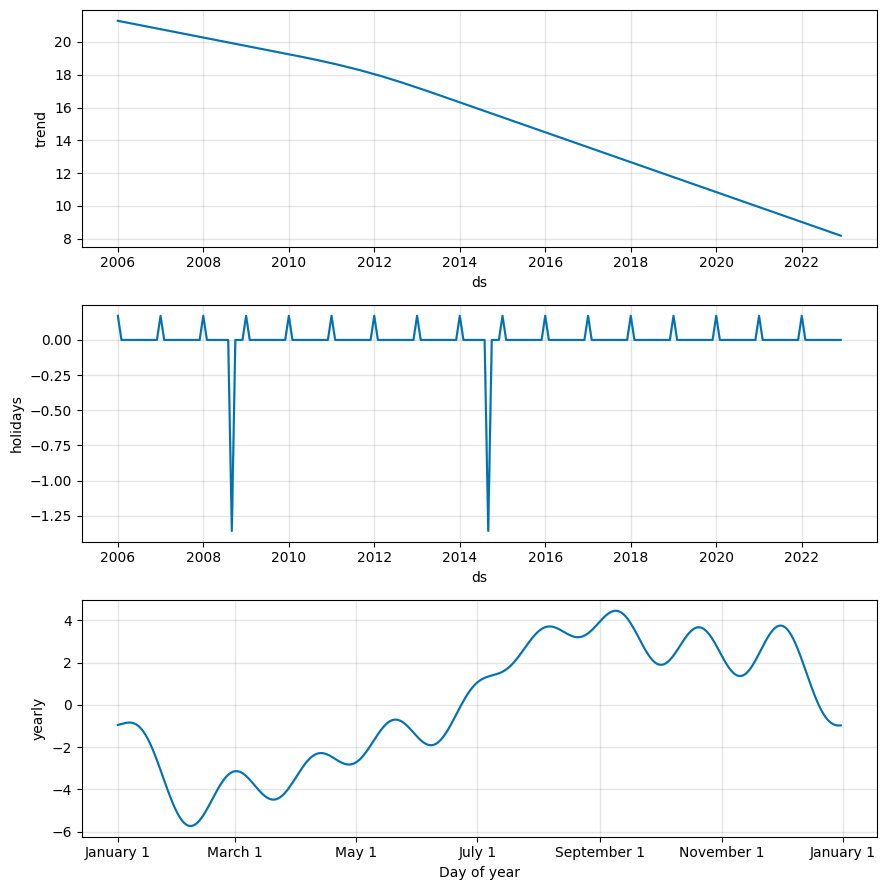

In [122]:
fig = m.plot_components(forecast)

In [123]:
predictions = forecast.iloc[-12:]['yhat']
predictions = round(predictions, 0).astype(int)
predictions


192     8
193     4
194     6
195     5
196     6
197     7
198    10
199    12
200    12
201    10
202    11
203    12
Name: yhat, dtype: int32

In [124]:
test['y']

192    17
193    17
194    28
195    16
196    17
197    17
198    26
199    18
200    18
201    13
202    15
203    14
Name: y, dtype: int64

In [125]:
from sklearn.metrics import mean_squared_error as MSE

error = np.sqrt(MSE(test['y'], predictions))
print(f'RMSE Error: {error}')


RMSE Error: 10.927793311857004


In [105]:
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric

In [106]:
print(len(df_final_counts))
print(len(df_final_counts)/12)


204
17.0


In [107]:
# Initial 5 years training period
initial = 3 * 365
initial = str(initial) + ' days'
# Fold every 5 years
period = 3 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [126]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()


  0%|          | 0/27 [00:00<?, ?it/s]

11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:22 - cmdstanpy - INFO - Chain [1] done processing
11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:22 - cmdstanpy - INFO - Chain [1] done processing
11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:22 - cmdstanpy - INFO - Chain [1] done processing
11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:22 - cmdstanpy - INFO - Chain [1] done processing
11:48:22 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing
11:48:23 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing
11:48:23 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing
11:48:23 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing
11:48:23 - cmdstanpy - INFO - Chain [1] start processing
11:48:24 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2008-03-01,8.952,6.159,11.718,11,2008-02-08
1,2008-04-01,33.284,30.599,36.031,15,2008-02-08
2,2008-05-01,12.489,9.707,15.103,10,2008-02-08
3,2008-06-01,19.768,16.937,22.487,13,2008-02-08
4,2008-07-01,13.136,10.495,15.984,14,2008-02-08


In [129]:
df_p = performance_metrics(df_cv)
df_p.head()
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,41.721,6.459,5.016,0.369,0.279,0.308,0.625
1,41 days,41.516,6.443,4.974,0.360,0.247,0.301,0.625
2,42 days,38.573,6.211,4.815,0.355,0.247,0.298,0.625
3,43 days,39.083,6.252,4.920,0.360,0.253,0.305,0.625
4,46 days,39.627,6.295,4.986,0.368,0.279,0.315,0.625


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
206,359 days,50.043,7.074,5.875,0.439,0.310,0.375,0.562
207,360 days,49.386,7.027,5.745,0.428,0.310,0.366,0.562
208,362 days,43.439,6.591,5.457,0.405,0.302,0.359,0.578
209,364 days,36.980,6.081,5.065,0.378,0.310,0.342,0.625
210,365 days,40.555,6.368,5.214,0.378,0.302,0.340,0.594


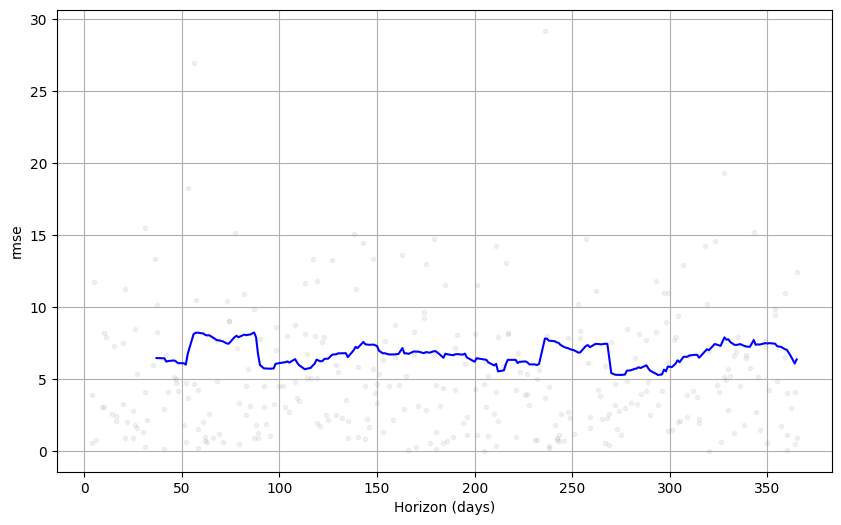

In [130]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [134]:
# Cross Validation with Hyperparameters Tuning

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, seasonality_mode='multiplicative').fit(df_final_counts)  # Fit model with given params
    #df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/29 [00:00<?, ?it/s]

12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing
12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:08 - cmdstanpy - INFO - Chain [1] done processing
12:33:08 - cmdstanpy - INFO - Chain [1] start processing
12:33:08 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:33:20 - cmdstanpy - INFO - Chain [1] start processing
12:33:20 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:22 - cmdstanpy - INFO - Chain [1] done processing
12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing
12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing
12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing
12:33:34 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing
12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing
12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing
12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing
12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing
12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:07 - cmdstanpy - INFO - Chain [1] done processing
12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing
12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:19 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing
12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing
12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing
12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing
12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1] done processing
12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:44 - cmdstanpy - INFO - Chain [1] done processing
12:34:44 - cmdstanpy - INFO - Chain [1] start processing
12:34:44 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  rmse
0                     0.001                    0.010 5.924
1                     0.001                    0.100 5.642
2                     0.001                    1.000 5.900
3                     0.001                   10.000 6.804
4                     0.010                    0.010 6.251
5                     0.010                    0.100 6.156
6                     0.010                    1.000 6.378
7                     0.010                   10.000 7.225
8                     0.100                    0.010 6.213
9                     0.100                    0.100 6.074
10                    0.100                    1.000 6.344
11                    0.100                   10.000 7.026
12                    0.500                    0.010 6.437
13                    0.500                    0.100 6.950
14                    0.500                    1.000 7.263
15                    0.500                   10.000 7.4

In [135]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


In [136]:
m = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')

m.fit(train)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)


12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing


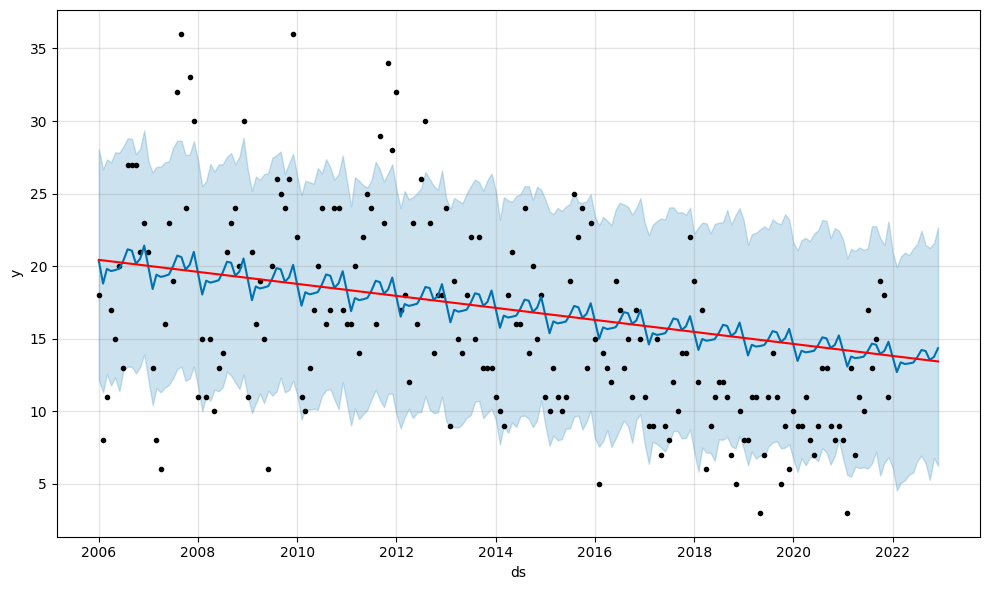

In [137]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<Axes: xlabel='ds'>

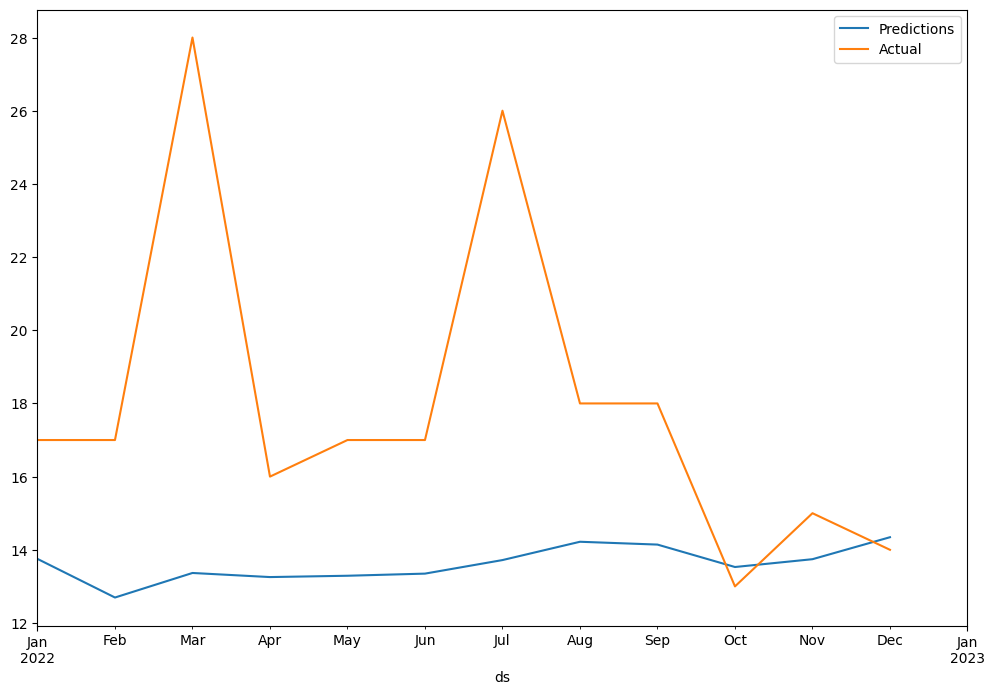

In [138]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Actual',legend=True, ax=ax, xlim=('2022-01-01','2023-01-01'))


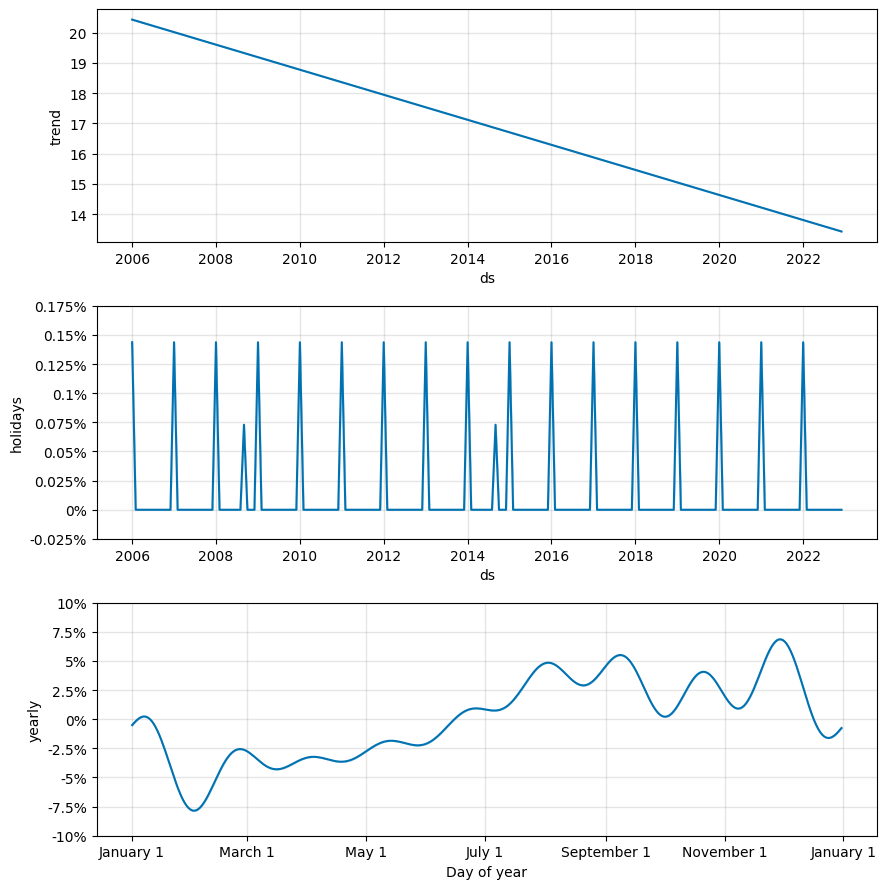

In [139]:
fig = m.plot_components(forecast)

In [140]:
predictions = forecast.iloc[-12:]['yhat']
predictions = round(predictions, 0).astype(int)
predictions

192    14
193    13
194    13
195    13
196    13
197    13
198    14
199    14
200    14
201    14
202    14
203    14
Name: yhat, dtype: int32

In [141]:
error = np.sqrt(MSE(test['y'], predictions))
print(f'RMSE Error: {error}')

RMSE Error: 6.251666444503684


In [108]:
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)
df_cv.head()


  0%|          | 0/4 [00:00<?, ?it/s]

10:53:08 - cmdstanpy - INFO - Chain [1] start processing
10:53:08 - cmdstanpy - INFO - Chain [1] done processing
10:53:08 - cmdstanpy - INFO - Chain [1] start processing
10:53:08 - cmdstanpy - INFO - Chain [1] done processing
10:53:08 - cmdstanpy - INFO - Chain [1] start processing
10:53:08 - cmdstanpy - INFO - Chain [1] done processing
10:53:09 - cmdstanpy - INFO - Chain [1] start processing
10:53:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-01-01,17.410,11.735,23.172,32,2011-12-04
1,2012-02-01,14.451,8.715,20.305,17,2011-12-04
2,2012-03-01,11.932,6.252,18.018,18,2011-12-04
3,2012-04-01,19.621,13.530,25.135,12,2011-12-04
4,2012-05-01,14.028,8.133,19.914,23,2011-12-04


In [109]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,72.748,8.529,6.782,0.334,0.410,0.363,0.500
1,59 days,21.154,4.599,3.772,0.257,0.257,0.256,0.750
2,60 days,14.609,3.822,2.897,0.182,0.175,0.201,0.750
3,61 days,5.447,2.334,2.007,0.161,0.175,0.171,1.000
4,62 days,7.391,2.719,2.674,0.390,0.240,0.326,1.000
5,88 days,14.191,3.767,3.286,0.405,0.309,0.360,1.000
6,89 days,26.349,5.133,4.381,0.448,0.396,0.426,0.750
7,90 days,35.671,5.972,5.361,0.345,0.396,0.441,0.500
8,119 days,41.583,6.448,5.969,0.443,0.486,0.480,0.250
9,120 days,30.217,5.497,4.985,0.487,0.575,0.453,0.500


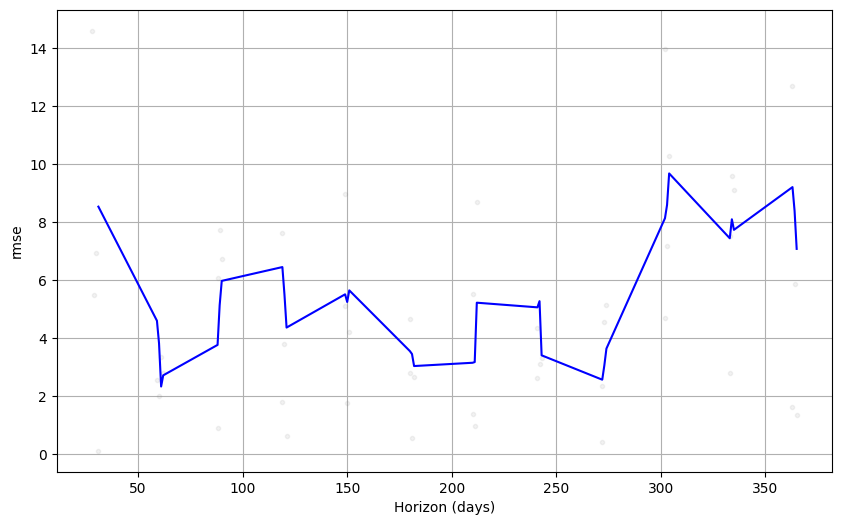

In [110]:
plot_cross_validation_metric(df_cv, metric='rmse');

In [60]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
204,2023-01-01,10.051,3.611,16.679
205,2023-02-01,5.834,-1.183,12.779
206,2023-03-01,8.386,2.067,15.318
207,2023-04-01,7.247,0.296,14.219
208,2023-05-01,7.982,0.152,14.949
209,2023-06-01,9.167,2.843,16.500
210,2023-07-01,11.898,5.150,18.237
211,2023-08-01,13.645,6.604,20.211
212,2023-09-01,13.914,6.915,20.738
213,2023-10-01,11.815,4.647,18.738


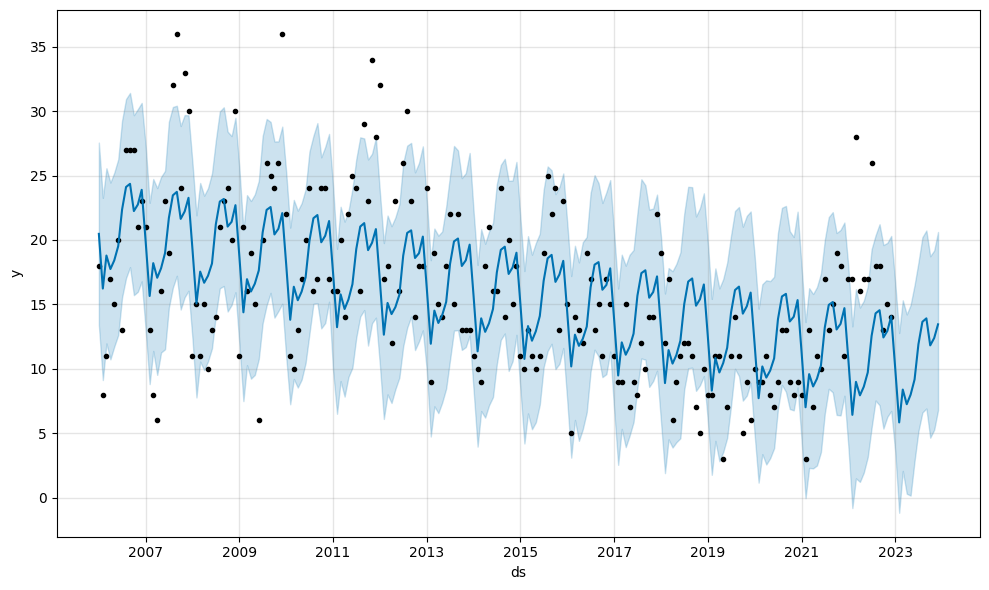

In [61]:
m.plot(forecast);

ConversionError: Failed to convert value(s) to axis units: '2020-01-01'

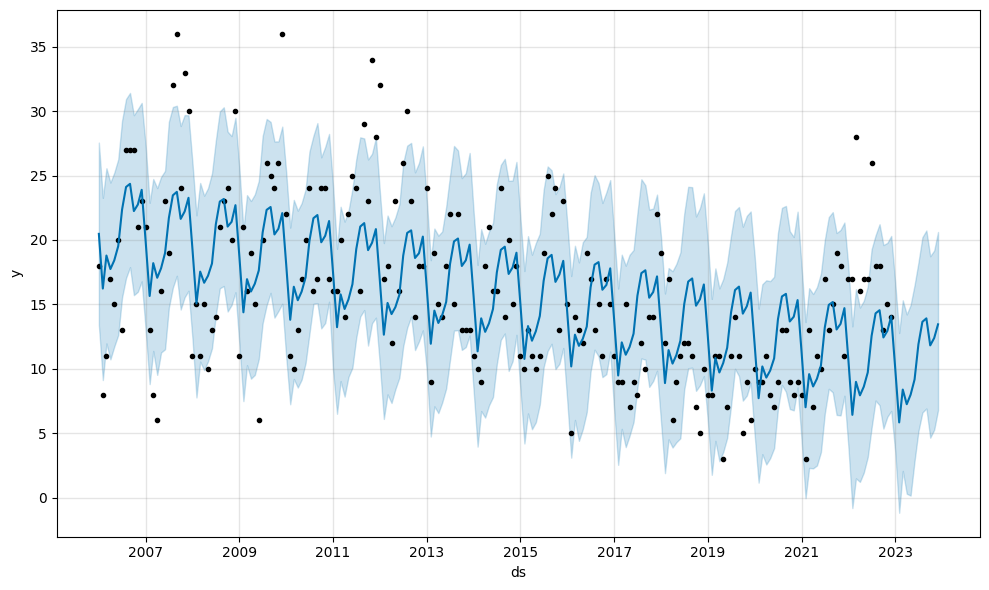

In [67]:
m.plot(forecast)
plt.xlim('2020-01-01','2024-01-01');

<div class="alert alert-info"><strong>
TRY TO PREDICT USING SARIMA
</strong></div>

In [50]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#auto_arima(df_final_counts['count'], seasonal=True, m=12, start_p=0, start_q=0, n_jobs=-1).summary()


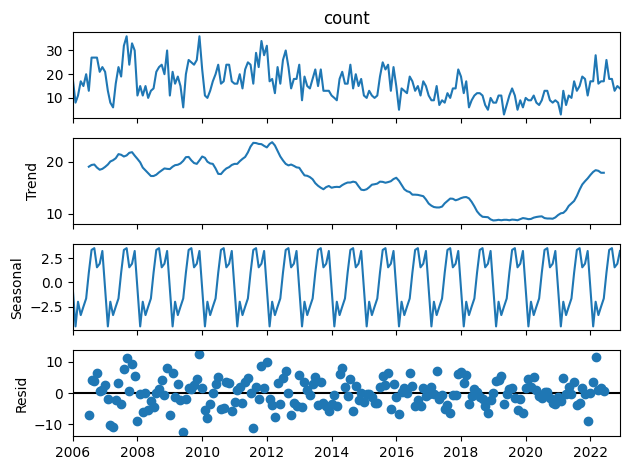

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = df_final_counts.set_index('burglary_date')
result = seasonal_decompose(df['count'], model='additive')
result.plot();


In [21]:
cut_of_month = '2021-12'
train = df_final_counts[df_final_counts.burglary_date <= cut_of_month]
test  = df_final_counts[df_final_counts.burglary_date > cut_of_month]
train.shape
test.shape


(192, 2)

(12, 2)

In [28]:
# Here I am doing my oen Cross Validation, to find out the best parameters to use

from sklearn.metrics import mean_squared_error as MSE
from itertools import product

start = len(train)
end   = len(train) + len(test) - 1
#print(start, end)

best_error = 99999
results_list = []

p_range = range(3)
d_range = range(3)
q_range = range(3)
P_range = range(3)
D_range = range(3)
Q_range = range(3)

parameters = list(product(p_range, d_range, q_range, P_range, D_range, Q_range))

for i, params in enumerate(parameters):
    order_params = params[:3]
    seasonal_order_params = params[3:]
    model = SARIMAX(train['count'], order=order_params, seasonal_order=(*seasonal_order_params,12))     #, enforce_invertibility=False)
    model.initialize_approximate_diffuse()
    results = model.fit()

    predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions')
    predictions = round(predictions, 0).astype(int)

    error = np.sqrt(MSE(test['count'], predictions))

    if (error < best_error):
        best_error = error
        results_list += [(*params, best_error)]

    if i % 20 == 0:
        print(f'{i}/{len(list(parameters))}')


results_df = pd.DataFrame(results_list, columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'RMSE']).sort_values(by='RMSE')           

0/729
20/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


40/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


60/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


80/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


100/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


120/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


140/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


160/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


180/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


200/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


220/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

240/729
260/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


280/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


300/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


320/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


340/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


360/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


380/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

400/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


420/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


440/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

460/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

480/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

500/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


520/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

540/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

560/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

580/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


600/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

620/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


640/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

660/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


680/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

700/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

720/729


c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python 3-9-13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

In [29]:
results_df

,p,d,q,P,D,Q,RMSE
16,0,2,2,0,2,2,3.536
15,0,1,1,0,2,2,4.699
14,0,1,1,0,0,1,5.323
13,0,1,1,0,0,0,5.874
12,0,1,0,1,2,1,5.951
11,0,1,0,0,2,2,6.727
10,0,1,0,0,2,1,6.916
9,0,1,0,0,1,0,7.077
8,0,1,0,0,0,2,7.773
7,0,1,0,0,0,1,7.842


In [30]:
order_param_p = 0
order_param_d = 2
order_param_q = 2
seas_param_P = 0
seas_param_D = 2
seas_param_Q = 2


In [31]:
model = SARIMAX(train['count'], order=(order_param_p, order_param_d, order_param_q), 
                seasonal_order=(seas_param_P, seas_param_D, seas_param_Q, 12))
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                  192
Model:             SARIMAX(0, 2, 2)x(0, 2, 2, 12)   Log Likelihood                -553.184
Date:                            Sun, 18 Feb 2024   AIC                           1116.367
Time:                                    09:30:26   BIC                           1131.927
Sample:                                         0   HQIC                          1122.683
                                            - 192                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7868      3.810     -0.469      0.639      -9.255       5.682
ma.L2          0.7870      2.985      0.264      0.792      -5.063       6.637
ma.S.L12      -1.9994      3.819     -0.523      0.601      -9.485       5.486
ma.S.L24       0.9996      3.825      0.261      0.794      -6.497       8.497
sigma2        22.7721      0.336     67.854      0.000      22.114      23.430
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.35   Prob(JB):                         0.88
Heteroskedasticity (H):               0.44   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.72e+19. Standard errors may be unstable.
"""

In [32]:
# Obtain predicted values
start = len(train)
end   = len(train) + len(test) - 1
print(start, end)
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions')


192 203


In [33]:
predictions

192   16.375
193   12.633
194   19.474
195   16.613
196   14.900
197   15.614
198   20.326
199   18.487
200   17.046
201   16.608
202   16.295
203   16.491
Name: Predictions, dtype: float64

In [34]:
predictions = round(predictions, 0).astype(int)
predictions

192    16
193    13
194    19
195    17
196    15
197    16
198    20
199    18
200    17
201    17
202    16
203    16
Name: Predictions, dtype: int32

In [35]:
# Compare predictions to expected values
for i in range(start, end+1):
    #print(f"predicted={predictions[i]:<11.10}, expected={test['count'][i]}")
    print(f"predicted={predictions[i]} expected={test['count'][i]}")
    

predicted=16 expected=17
predicted=13 expected=17
predicted=19 expected=28
predicted=17 expected=16
predicted=15 expected=17
predicted=16 expected=17
predicted=20 expected=26
predicted=18 expected=18
predicted=17 expected=18
predicted=17 expected=13
predicted=16 expected=15
predicted=16 expected=14


<Axes: title={'center': 'Real Manufacturing and Trade Inventories'}>

[Text(0.5, 0, ''), Text(0, 0.5, 'Chained 2012 Dollars')]

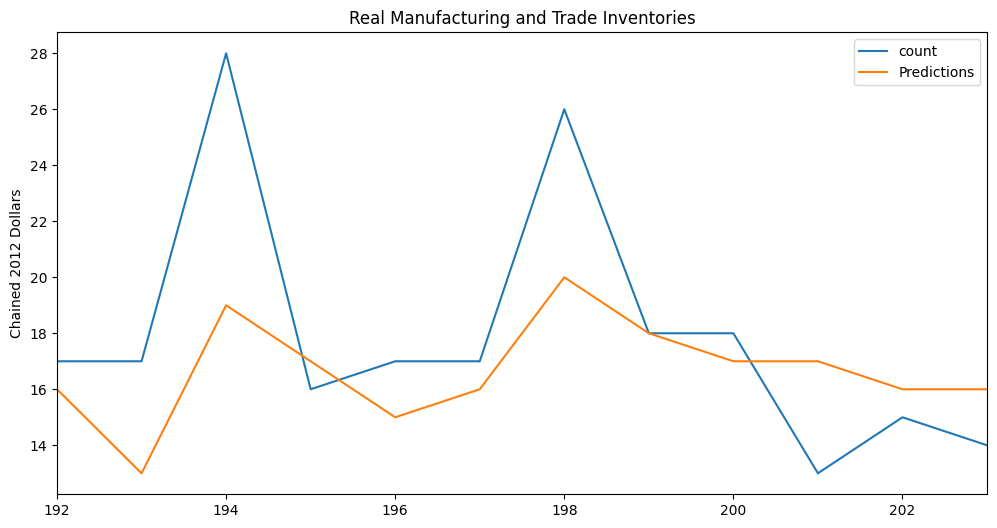

In [36]:
# Plot predictions against known values
title = 'Actuals vs. Predictions'
ylabel = 'Count'
xlabel = 'Month #'

ax = test['count'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
#ax.yaxis.set_major_formatter(formatter);


In [37]:
from sklearn.metrics import mean_squared_error as MSE

error = np.sqrt(MSE(test['count'], predictions))
print(f'RMSE Error: {error}')


RMSE Error: 3.6742346141747673


### Retrain the model on the full data, and forecast the future

In [44]:
model = SARIMAX(df_final_counts['count'], order=(order_param_p, order_param_d, order_param_q), 
                seasonal_order=(seas_param_P, seas_param_D, seas_param_Q, 12))
results = model.fit()
fcast = results.predict(len(df_final_counts),len(df_final_counts)+12, typ='levels').rename('Forecast')

fcast = round(fcast, 0).astype(int)

<Axes: title={'center': '2023 Predictions'}>

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Count')]

[Text(0, 0, '2006'),
 Text(12, 0, '2007'),
 Text(24, 0, '2008'),
 Text(36, 0, '2009'),
 Text(48, 0, '2010'),
 Text(60, 0, '2011'),
 Text(72, 0, '2012'),
 Text(84, 0, '2013'),
 Text(96, 0, '2014'),
 Text(108, 0, '2015'),
 Text(120, 0, '2016'),
 Text(132, 0, '2017'),
 Text(144, 0, '2018'),
 Text(156, 0, '2019'),
 Text(168, 0, '2020'),
 Text(180, 0, '2021'),
 Text(192, 0, '2022'),
 Text(204, 0, '2023')]

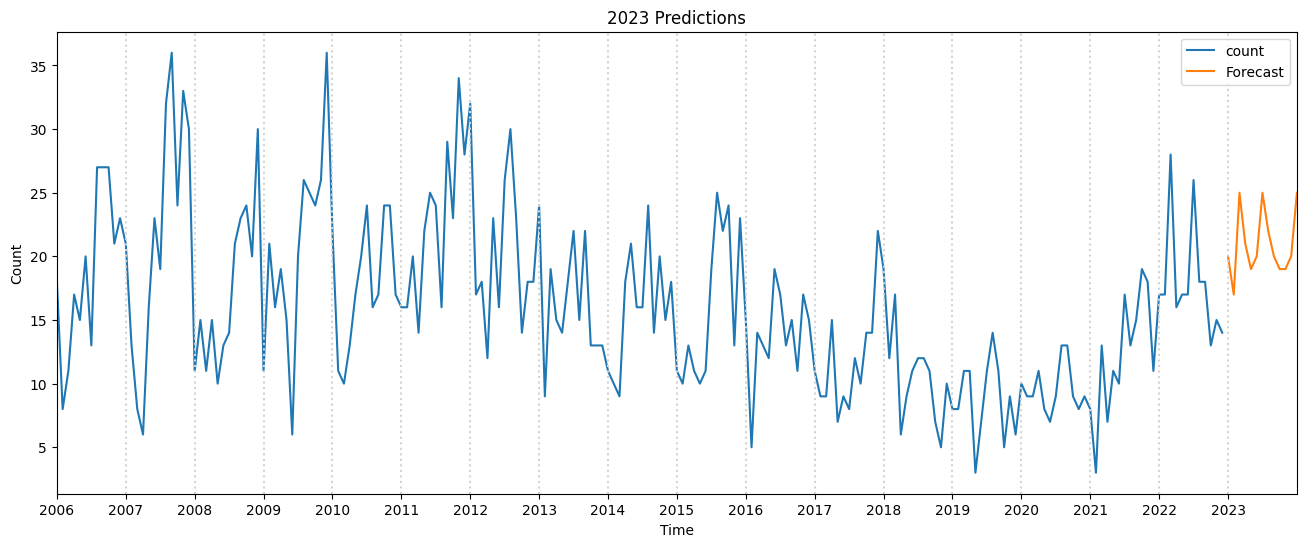

In [45]:
# Plot fiven data + predictions

title = '2023 Predictions'
ylabel = 'Count'
xlabel = 'Time'
ax = df_final_counts['count'].plot(legend=True, figsize=(16, 6), title=title)
fcast.plot(legend=True, ax=ax)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
x_labels = [f'{y}' for y in range(2006, 2024)]
ax.set_xticks(range(0, len(df_final_counts)+12, 12))
ax.set_xticklabels(x_labels)
for y in range(0, len(df_final_counts)+12, 12):
    ax.axvline(y, color='lightgray', linestyle=':')


In [49]:
last_q = sum(fcast[-3:])
print('Forecasted home burglaries for precinct 44 for the last quarter of 2023: ' + str(last_q))

Forecasted home burglaries for precinct 44 for the last quarter of 2023: 64
